<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE1] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

Thanks to **François Chollet** whose VAE example has greatly inspired this example.  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from importlib import reload
from IPython.display import display,Image,Markdown,HTML
import h5py

from skimage import io
from skimage.util import random_noise

import modules.AE
from modules.AE           import AE
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('AE1')

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : AE1
Run time             : Tuesday 29 December 2020, 12:26:31
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
Running mode         : full
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Prepare data
### 2.1 - Get MNIST dataset

In [2]:
x_data, y_data = Loader_MNIST.get()

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)


### 2.2 - Add noise to dataset
We will add noise to our input dataset (x_data)  
Our goal is to predict noiselessly data (y_data)

In [3]:
def noise_it(x_data, about):
    for i,image in enumerate(x_data):
        pwk.update_progress(about,i+1,len(x_data))
        image=random_noise(image, mode='gaussian', mean=0, var=0.3)
        image=random_noise(image, mode='s&p',      amount=0.2, salt_vs_pepper=0.5)
        image=random_noise(image, mode='poisson') 
        image=random_noise(image, mode='speckle',  mean=0, var=0.1)
        x_data[i]=image
    return x_data


# ---- What we want to predict
#
y_data = np.copy(x_data)

# ---- Add noise to input data
#
x_data = noise_it(x_data, 'Add noise to x_train :')


Add noise to x_train : [########################################] 100.0% of 70000


### 2.3 - Have a look

Noisy dataset (x_data) :  (70000, 28, 28, 1)
Clean dataset (y_data) :  (70000, 28, 28, 1)


<br>**Noisy images (input data)**

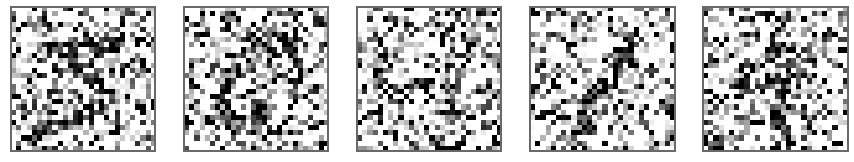

<br>**Original images we want to obtain (output data)**

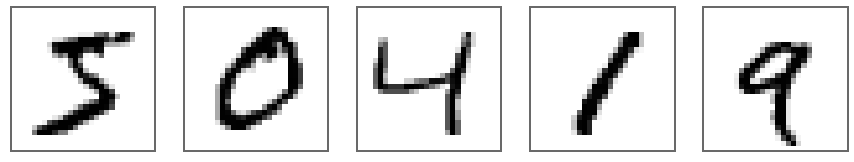

In [4]:
print('Noisy dataset (x_data) : ',x_data.shape)
print('Clean dataset (y_data) : ',y_data.shape)

pwk.subtitle('Noisy images (input data)')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='01-noisy')
pwk.subtitle('Original images we want to obtain (output data)')
pwk.plot_images(y_data[:5], None, indices='all', columns=5, x_size=3,y_size=3, interpolation=None, save_as='02-original')


### 2.4 - Shuffle and split dataset

In [5]:
p = np.random.permutation(len(x_data))
x_data, y_data = x_data[p], y_data[p]
x_train, y_train = x_data[:60000], y_data[:60000]
x_test,  y_test  = x_data[60000:], y_data[60000:]

print(f'x_train:{x_train.shape}  y_train:{y_train.shape}')
print(f'x_test :{x_test.shape}  y_test :{y_test.shape}')

x_train:(60000, 28, 28, 1)  y_train:(60000, 28, 28, 1)
x_test :(10000, 28, 28, 1)  y_test :(10000, 28, 28, 1)


### 2.5 - Save it

In [6]:
pwk.mkdir('./data')

with h5py.File('./data/mnist-noisy.h5', "w") as f:
    f.create_dataset("x_train", data=x_train)
    f.create_dataset("y_train", data=y_train)
    f.create_dataset("x_test",  data=x_test)
    f.create_dataset("y_test",  data=y_test)
    print('Saved.')

Saved.


## Step 3 - Build model

In [7]:
latent_dim = 10

#### Encoder

In [8]:
reload(modules.AE)
from modules.AE          import AE

inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [9]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### AE


In [10]:
ae = AE(encoder, decoder)

ae.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy')

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [11]:
# ---- Callback : Images
pwk.mkdir('./run/images')
filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=x_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
pwk.mkdir('./run/models')
filename = './run/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = './run/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]

In [12]:
%%time

n          = 60000
batch_size = 128
epochs     = 30

history = ae.fit(x_train[:n],y_train[:n], epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/30
469/469 [==============================] - 13s 5ms/step - loss: 0.3288
           (saved) Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1978
           (saved) Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1827
           (saved) Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1760
           (saved) Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1721
           (saved) Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1698
           (saved) Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1686
           (saved) Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1670
           (saved) Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1661
           (saved) Epoch 10/30
469/469 [==============================] - 2s 4ms/step - loss: 0.1654
           (saved

## Step 5 - History

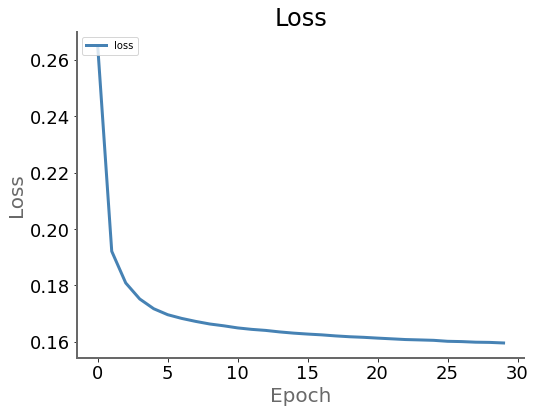

In [13]:
pwk.plot_history(history,  plot={"Loss":['loss']}, save_as='03-history')

## Step 7 - Learning progression

<br>**Real images :**

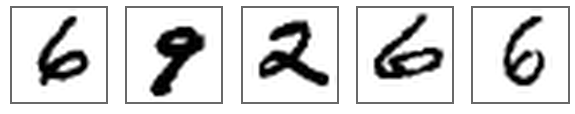

<br>**Noisy images :**

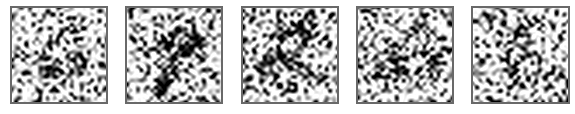

<br>**Learning...**

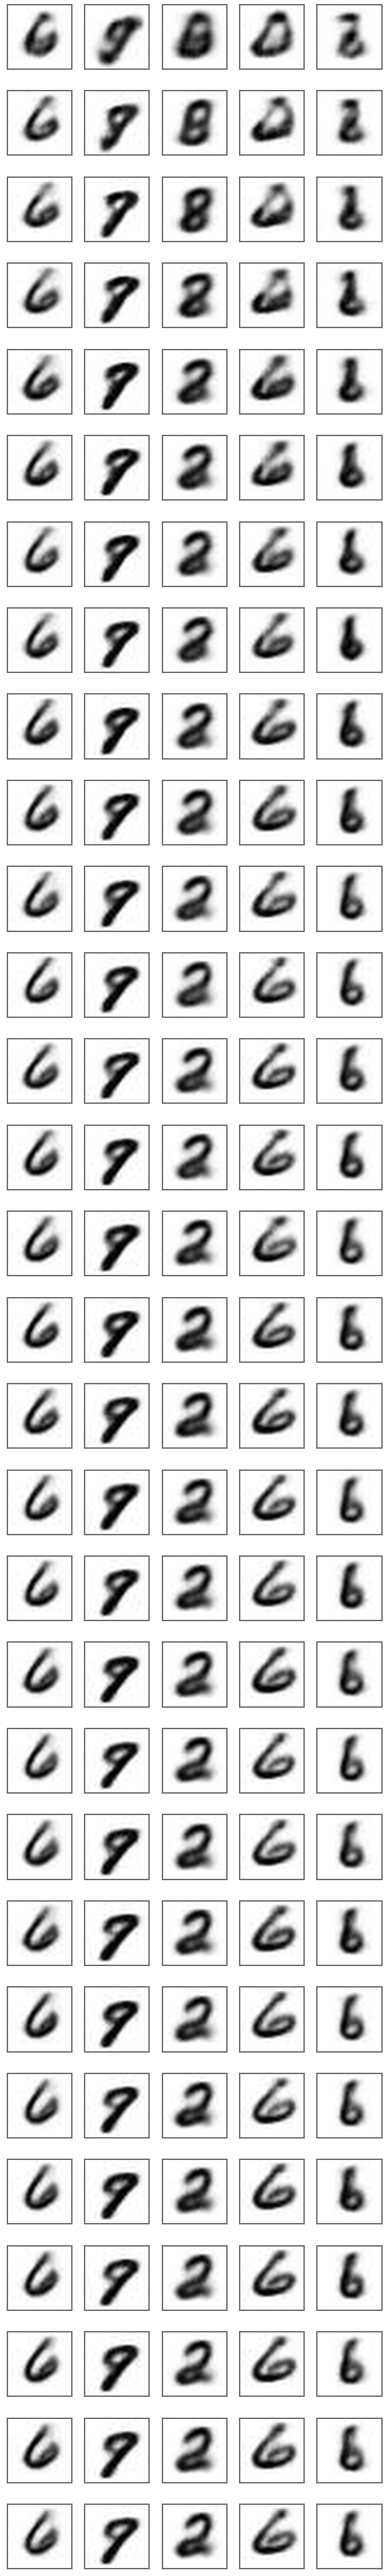

<br>**Noisy images :**

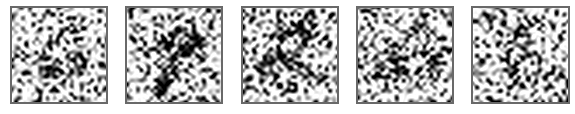

<br>**Real images :**

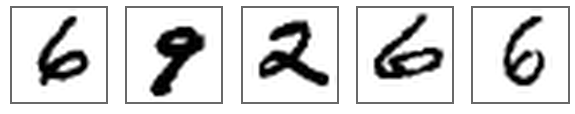

In [14]:
imgs=[]
labels=[]
for epoch in range(epochs):
    for i in range(5):
        filename = './run/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='05-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='06-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(x_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(y_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


In [15]:
pwk.end()

End time is : Monday 28 December 2020, 23:56:09
Duration is : 00:03:41 536ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>